# SQLi Detector Model Evaluation

Compare multiple generations of trained models against the evaluation dataset.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## 1. Configuration

Specify how many models you want to evaluate and their paths.

In [2]:
# Number of models to evaluate
NUM_MODELS = 2  # Change this to the number of model generations you have

# Define your models here - add/remove entries as needed
MODELS = [
    {
        "name": "Generation 1",
        "model_path": "generations/1st_train_session/sqli_detector_model.joblib",
        "vectorizer_path": "generations/1st_train_session/sqli_vectorizer.joblib"
    },
    {
        "name": "Generation 2",
        "model_path": "generations/2nd_train_session/sqli_detector_model.joblib",
        "vectorizer_path": "generations/2nd_train_session/sqli_vectorizer.joblib"
    },
    {
         "name": "Generation 3",
         "model_path": "generations/3rd_train_session/sqli_detector_model.joblib",
         "vectorizer_path": "generations/3rd_train_session/sqli_vectorizer.joblib"
    },
]

# Evaluation dataset path
EVAL_DATASET = "evaluation_set.csv"

print(f"Configured to evaluate {len(MODELS)} model(s)")

Configured to evaluate 3 model(s)


## 2. Load Evaluation Dataset

In [3]:
# Load the evaluation dataset
df = pd.read_csv(EVAL_DATASET)

print(f"Loaded {len(df)} evaluation queries")
print(f"\nLabel distribution:")
print(df['label'].value_counts().rename({0: 'Benign', 1: 'Malicious'}))
print(f"\nCategories: {df['category'].nunique()} unique")
print(df['category'].value_counts().head(15))

Loaded 509 evaluation queries

Label distribution:
label
Benign       258
Malicious    251
Name: count, dtype: int64

Categories: 42 unique
category
complex_benign        55
edge_case             42
tautology             30
union                 28
stacked               27
advanced              26
boolean_blind         22
time_blind            22
error_based           19
simple_select         19
simple_where          15
obfuscated_encoded    14
obfuscated_case       12
obfuscated_comment    12
minimal               11
Name: count, dtype: int64


In [4]:
# Extract features and labels
X_eval = df['query'].tolist()
y_true = df['label'].values
categories = df['category'].values
descriptions = df['description'].values

print(f"Ready to evaluate {len(X_eval)} queries")

Ready to evaluate 509 queries


## 3. Load Models and Evaluate

In [5]:
def load_model_and_vectorizer(model_config):
    """Load a model and its vectorizer."""
    try:
        model = joblib.load(model_config['model_path'])
        vectorizer = joblib.load(model_config['vectorizer_path'])
        return model, vectorizer, None
    except Exception as e:
        return None, None, str(e)

def evaluate_model(model, vectorizer, X, y_true):
    """Evaluate a model and return metrics."""
    X_transformed = vectorizer.transform(X)
    y_pred = model.predict(X_transformed)
    
    # Try to get probabilities for ROC-AUC
    try:
        y_proba = model.predict_proba(X_transformed)[:, 1]
        roc_auc = roc_auc_score(y_true, y_proba)
    except:
        y_proba = None
        roc_auc = None
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    return metrics

# Evaluate all models
results = {}
for config in MODELS:
    name = config['name']
    print(f"\n{'='*60}")
    print(f"Evaluating: {name}")
    print(f"{'='*60}")
    
    model, vectorizer, error = load_model_and_vectorizer(config)
    
    if error:
        print(f"❌ Failed to load: {error}")
        results[name] = {'error': error}
        continue
    
    print(f"✅ Model loaded successfully")
    
    metrics = evaluate_model(model, vectorizer, X_eval, y_true)
    results[name] = metrics
    
    print(f"\n📊 Results:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1 Score:  {metrics['f1']:.4f}")
    if metrics['roc_auc']:
        print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")


Evaluating: Generation 1
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.6031
   Precision: 0.5541
   Recall:    1.0000
   F1 Score:  0.7131
   ROC-AUC:   0.9946

Evaluating: Generation 2
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.8212
   Precision: 0.7339
   Recall:    1.0000
   F1 Score:  0.8465
   ROC-AUC:   0.9973

Evaluating: Generation 3
✅ Model loaded successfully

📊 Results:
   Accuracy:  0.8369
   Precision: 0.7515
   Recall:    1.0000
   F1 Score:  0.8581
   ROC-AUC:   0.9975


## 4. Comparison Summary

In [6]:
# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    if 'error' not in metrics:
        comparison_data.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'] if metrics['roc_auc'] else 'N/A'
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
}).background_gradient(cmap='RdYlGn', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score']))


MODEL COMPARISON SUMMARY


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Generation 1,0.6031,0.5541,1.0000,0.7131,0.994642
1,Generation 2,0.8212,0.7339,1.0000,0.8465,0.997329
2,Generation 3,0.8369,0.7515,1.0000,0.8581,0.997545


## 5. Confusion Matrices

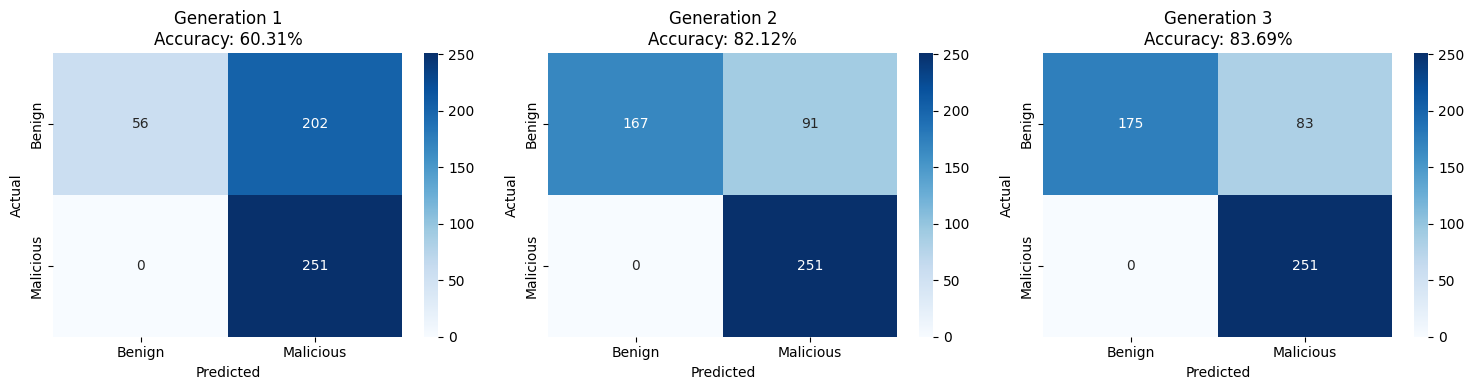


💾 Saved: model_comparison_confusion.png


In [7]:
# Plot confusion matrices for all models
valid_models = [(name, m) for name, m in results.items() if 'error' not in m]
n_models = len(valid_models)

if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, metrics) in zip(axes, valid_models):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Benign', 'Malicious'],
                    yticklabels=['Benign', 'Malicious'])
        ax.set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.2%}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.savefig('model_comparison_confusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Saved: model_comparison_confusion.png")

## 6. Metrics Bar Chart

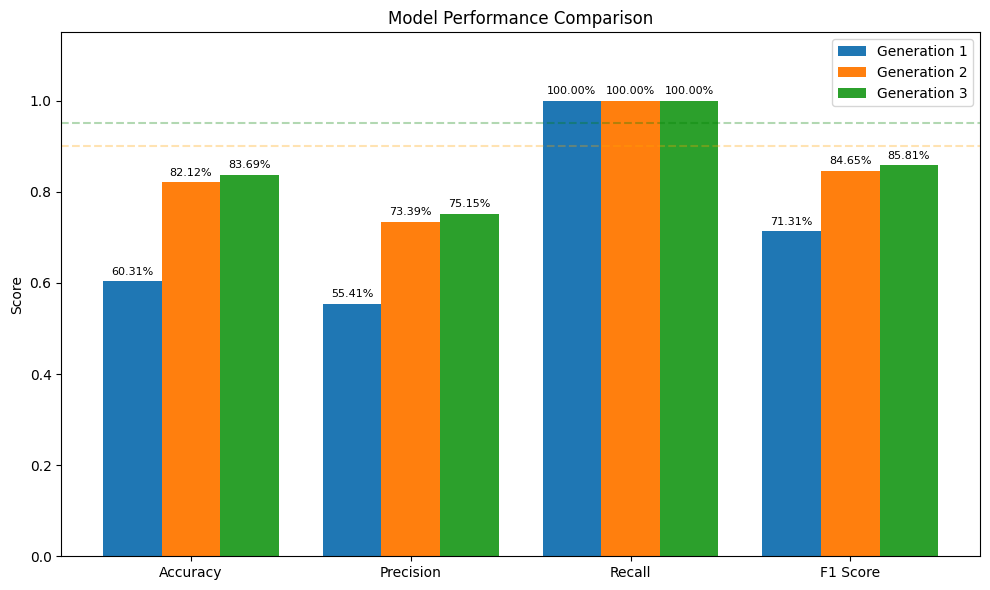


💾 Saved: model_comparison_metrics.png


In [8]:
# Bar chart comparing metrics
if len(comparison_data) > 0:
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(metrics_to_plot))
    width = 0.8 / len(comparison_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, row in enumerate(comparison_data):
        values = [row[m] for m in metrics_to_plot]
        offset = (i - len(comparison_data)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=row['Model'])
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.2%}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.legend()
    ax.set_ylim(0, 1.15)
    ax.axhline(y=0.95, color='g', linestyle='--', alpha=0.3, label='95% threshold')
    ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.3, label='90% threshold')
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Saved: model_comparison_metrics.png")

## 7. Per-Category Analysis

In [9]:
def analyze_by_category(name, y_pred, df):
    """Analyze performance by category."""
    df_analysis = df.copy()
    df_analysis['predicted'] = y_pred
    df_analysis['correct'] = df_analysis['label'] == df_analysis['predicted']
    
    # Group by category
    category_stats = df_analysis.groupby('category').agg({
        'correct': ['sum', 'count', 'mean'],
        'label': 'first'
    }).round(4)
    category_stats.columns = ['correct', 'total', 'accuracy', 'label_type']
    category_stats['label_type'] = category_stats['label_type'].map({0: 'Benign', 1: 'Malicious'})
    category_stats = category_stats.sort_values('accuracy')
    
    return category_stats, df_analysis

# Analyze first valid model by category
for name, metrics in results.items():
    if 'error' not in metrics:
        print(f"\n{'='*60}")
        print(f"Category Analysis: {name}")
        print(f"{'='*60}")
        
        cat_stats, df_analyzed = analyze_by_category(name, metrics['y_pred'], df)
        
        # Show worst performing categories
        print("\n⚠️ Worst Performing Categories:")
        display(cat_stats.head(10))
        
        # Show best performing categories
        print("\n✅ Best Performing Categories:")
        display(cat_stats.tail(10))


Category Analysis: Generation 1

⚠️ Worst Performing Categories:


,correct,total,accuracy,label_type
category,,,,
order_by,0,2,0.0000,Benign
pagination,0,3,0.0000,Benign
date_compare,0,6,0.0000,Benign
null_check,0,5,0.0000,Benign
minimal,0,11,0.0000,Benign
limit,0,2,0.0000,Benign
edge_case,1,42,0.0238,Benign
complex_benign,4,55,0.0727,Benign
subquery,1,9,0.1111,Benign



✅ Best Performing Categories:


,correct,total,accuracy,label_type
category,,,,
obfuscated_case,12,12,1.0,Malicious
union_full,2,2,1.0,Malicious
full_injection_update,4,4,1.0,Malicious
full_injection_select,10,10,1.0,Malicious
full_injection_insert,4,4,1.0,Malicious
full_injection_delete,4,4,1.0,Malicious
error_based,19,19,1.0,Malicious
boolean_blind,22,22,1.0,Malicious
obfuscated_whitespace,5,5,1.0,Malicious



Category Analysis: Generation 2

⚠️ Worst Performing Categories:


,correct,total,accuracy,label_type
category,,,,
order_by,0,2,0.0000,Benign
minimal,0,11,0.0000,Benign
complex_benign,18,55,0.3273,Benign
join,3,7,0.4286,Benign
edge_case,24,42,0.5714,Benign
order_limit,3,5,0.6000,Benign
delete,3,5,0.6000,Benign
null_check,3,5,0.6000,Benign
insert,4,6,0.6667,Benign



✅ Best Performing Categories:


,correct,total,accuracy,label_type
category,,,,
full_injection_update,4,4,1.0,Malicious
full_injection_select,10,10,1.0,Malicious
full_injection_insert,4,4,1.0,Malicious
full_injection_delete,4,4,1.0,Malicious
error_based,19,19,1.0,Malicious
distinct,5,5,1.0,Benign
boolean_blind,22,22,1.0,Malicious
aggregate,11,11,1.0,Benign
obfuscated_concat,7,7,1.0,Malicious



Category Analysis: Generation 3

⚠️ Worst Performing Categories:


,correct,total,accuracy,label_type
category,,,,
join,2,7,0.2857,Benign
complex_benign,18,55,0.3273,Benign
minimal,4,11,0.3636,Benign
edge_case,23,42,0.5476,Benign
delete,3,5,0.6000,Benign
null_check,3,5,0.6000,Benign
insert,4,6,0.6667,Benign
group_by,5,7,0.7143,Benign
like,5,7,0.7143,Benign



✅ Best Performing Categories:


,correct,total,accuracy,label_type
category,,,,
full_injection_update,4,4,1.0,Malicious
full_injection_select,10,10,1.0,Malicious
full_injection_insert,4,4,1.0,Malicious
full_injection_delete,4,4,1.0,Malicious
error_based,19,19,1.0,Malicious
distinct,5,5,1.0,Benign
boolean_blind,22,22,1.0,Malicious
aggregate,11,11,1.0,Benign
obfuscated_concat,7,7,1.0,Malicious


## 8. Misclassified Examples

In [10]:
def show_misclassified(name, y_pred, df, n=20):
    """Show misclassified examples."""
    df_analysis = df.copy()
    df_analysis['predicted'] = y_pred
    df_analysis['correct'] = df_analysis['label'] == df_analysis['predicted']
    
    misclassified = df_analysis[~df_analysis['correct']]
    
    # False Positives (benign marked as malicious)
    fp = misclassified[misclassified['label'] == 0]
    
    # False Negatives (malicious marked as benign)
    fn = misclassified[misclassified['label'] == 1]
    
    return fp, fn, len(misclassified)

# Show misclassified for each model
for name, metrics in results.items():
    if 'error' not in metrics:
        print(f"\n{'='*60}")
        print(f"Misclassified Examples: {name}")
        print(f"{'='*60}")
        
        fp, fn, total_wrong = show_misclassified(name, metrics['y_pred'], df)
        
        print(f"\nTotal misclassified: {total_wrong} / {len(df)} ({total_wrong/len(df):.2%})")
        
        print(f"\n🔴 FALSE POSITIVES (Benign → Malicious): {len(fp)}")
        if len(fp) > 0:
            display(fp[['query', 'category', 'description']].head(15))
        
        print(f"\n🟡 FALSE NEGATIVES (Malicious → Benign): {len(fn)}")
        if len(fn) > 0:
            display(fn[['query', 'category', 'description']].head(15))


Misclassified Examples: Generation 1

Total misclassified: 202 / 509 (39.69%)

🔴 FALSE POSITIVES (Benign → Malicious): 202


,query,category,description
0,SELECT * FROM users;,simple_select,Basic table scan
1,SELECT * FROM products;,simple_select,Basic table scan
2,SELECT * FROM orders;,simple_select,Basic table scan
3,"SELECT id, name FROM users;",simple_select,Column subset
5,SELECT * FROM users WHERE id = 1;,simple_where,Simple ID lookup
6,SELECT * FROM users WHERE id = 42;,simple_where,Simple ID lookup
8,SELECT * FROM users WHERE status = 'active';,simple_where,String equality
11,SELECT * FROM users WHERE email = 'john@exampl...,simple_where,Email lookup
12,SELECT COUNT(*) FROM users;,aggregate,Simple count
13,SELECT COUNT(*) FROM orders;,aggregate,Simple count



🟡 FALSE NEGATIVES (Malicious → Benign): 0

Misclassified Examples: Generation 2

Total misclassified: 91 / 509 (17.88%)

🔴 FALSE POSITIVES (Benign → Malicious): 91


,query,category,description
18,SELECT * FROM users ORDER BY created_at DESC;,order_by,Order by date
19,SELECT * FROM products ORDER BY price ASC;,order_by,Order by price
22,SELECT * FROM users ORDER BY id DESC LIMIT 5;,order_limit,Order with limit
31,SELECT * FROM users WHERE email IS NOT NULL;,null_check,Not null check
35,SELECT * FROM users WHERE status = 'active' OR...,multi_condition,OR condition
36,SELECT * FROM users u JOIN orders o ON u.id = ...,join,Simple join
37,"SELECT u.name, o.total FROM users u JOIN order...",join,Join with columns
39,"SELECT u.email, COUNT(o.id) FROM users u LEFT ...",group_by,Group by with join
45,"INSERT INTO users (name, email) VALUES ('John ...",insert,Simple insert
52,SELECT 1;,minimal,Minimal query



🟡 FALSE NEGATIVES (Malicious → Benign): 0

Misclassified Examples: Generation 3

Total misclassified: 83 / 509 (16.31%)

🔴 FALSE POSITIVES (Benign → Malicious): 83


,query,category,description
31,SELECT * FROM users WHERE email IS NOT NULL;,null_check,Not null check
35,SELECT * FROM users WHERE status = 'active' OR...,multi_condition,OR condition
36,SELECT * FROM users u JOIN orders o ON u.id = ...,join,Simple join
37,"SELECT u.name, o.total FROM users u JOIN order...",join,Join with columns
39,"SELECT u.email, COUNT(o.id) FROM users u LEFT ...",group_by,Group by with join
45,"INSERT INTO users (name, email) VALUES ('John ...",insert,Simple insert
53,SELECT NOW();,minimal,Get current time
54,SELECT VERSION();,minimal,Version check
55,SELECT DATABASE();,minimal,Database name
56,SELECT * FROM users WHERE id = 1 AND 1=1;,edge_case,Looks suspicious but benign - valid AND



🟡 FALSE NEGATIVES (Malicious → Benign): 0


## 9. Interactive Query Tester

In [11]:
def test_query(query, model_index=0):
    """Test a single query against a specific model."""
    if model_index >= len(MODELS):
        print(f"Invalid model index. Available: 0 to {len(MODELS)-1}")
        return
    
    config = MODELS[model_index]
    model, vectorizer, error = load_model_and_vectorizer(config)
    
    if error:
        print(f"Error loading model: {error}")
        return
    
    X = vectorizer.transform([query])
    prediction = model.predict(X)[0]
    
    try:
        proba = model.predict_proba(X)[0]
        confidence = max(proba)
    except:
        confidence = None
    
    result = "🚨 MALICIOUS" if prediction == 1 else "✅ BENIGN"
    
    print(f"Model: {config['name']}")
    print(f"Query: {query[:100]}{'...' if len(query) > 100 else ''}")
    print(f"Result: {result}")
    if confidence:
        print(f"Confidence: {confidence:.2%}")

# Example usage:
print("Test queries with: test_query('YOUR SQL QUERY HERE', model_index=0)")
print("\nExample tests:")
test_query("SELECT * FROM users;")
print()
test_query("' OR '1'='1")

Test queries with: test_query('YOUR SQL QUERY HERE', model_index=0)

Example tests:
Model: Generation 1
Query: SELECT * FROM users;
Result: 🚨 MALICIOUS
Confidence: 98.48%

Model: Generation 1
Query: ' OR '1'='1
Result: 🚨 MALICIOUS
Confidence: 100.00%


## 10. Export Results

In [12]:
# Export comparison to CSV
if len(comparison_data) > 0:
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    print("💾 Saved: model_comparison_results.csv")

# Export detailed predictions for each model
for name, metrics in results.items():
    if 'error' not in metrics:
        df_export = df.copy()
        df_export['predicted'] = metrics['y_pred']
        df_export['correct'] = df_export['label'] == df_export['predicted']
        if metrics['y_proba'] is not None:
            df_export['malicious_probability'] = metrics['y_proba']
        
        filename = f"{name.lower().replace(' ', '_')}_predictions.csv"
        df_export.to_csv(filename, index=False)
        print(f"💾 Saved: {filename}")

print("\n✅ All results exported!")

💾 Saved: model_comparison_results.csv
💾 Saved: generation_1_predictions.csv
💾 Saved: generation_2_predictions.csv
💾 Saved: generation_3_predictions.csv

✅ All results exported!
